import library

In [2]:
import numpy as np
import os
import shutil
import random as rn
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from tensorflow import keras
from keras import models
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

Load Dataset

In [3]:
IMAGE_SIZE = 264
IMAGE_SIZE = 264
BATCH_SIZE = 16
Channels = 3
epochs = 10

In [4]:
dataset =tf.keras.preprocessing.image_dataset_from_directory(
    "Blood cell Cancer [ALL]",
    shuffle = True,
    image_size =(IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE

)

Found 3242 files belonging to 4 classes.


In [5]:
class_names = dataset.class_names
class_names

['Benign', '[Malignant] Pre-B', '[Malignant] Pro-B', '[Malignant] early Pre-B']

In [6]:
len(dataset)

203

In [7]:

for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].shape)


(264, 264, 3)


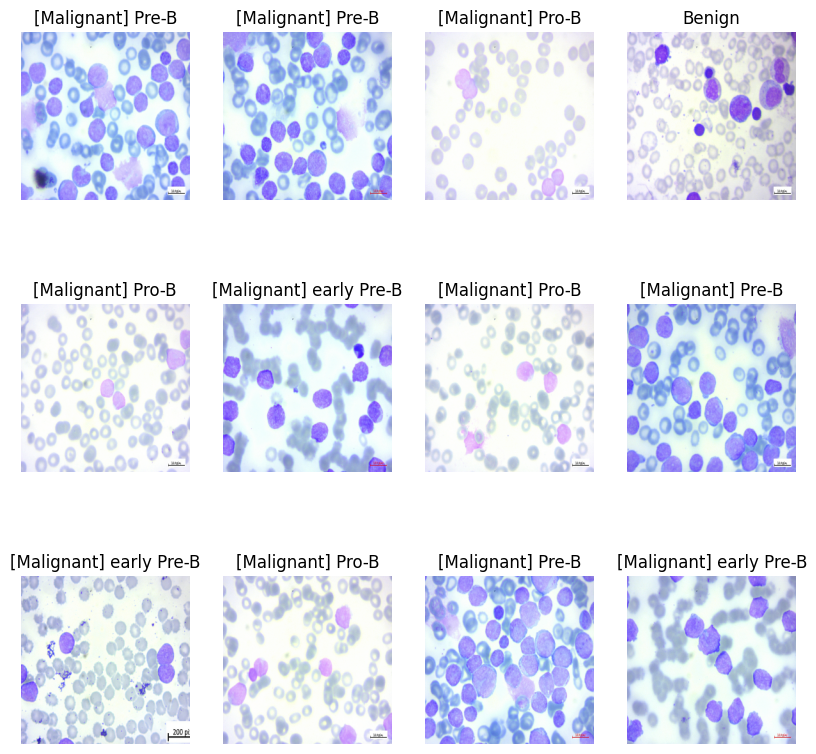

In [8]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
                 ax=plt.subplot(3,4,i+1)     
    
                 plt.imshow(image_batch[i].numpy().astype("uint8"))
                 plt.title(class_names[label_batch[i]])
                 plt.axis("off")
                  
                 
             

Spliting_Dataset

In [9]:
len(dataset)

203

In [10]:
#80% ==> training 
# 20% ==> 10% validation , 10% test

In [11]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    ds_size=len(ds)
    if shuffle:
      ds=ds.shuffle(shuffle_size,seed=12)
      train_size = int(train_split*ds_size)
      val_size = int(val_split*ds_size)

      train_ds= ds.take(train_size)
      val_ds = ds.skip(train_size).take(val_size)
      test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds,test_ds

In [12]:
train_ds, val_ds,test_ds =get_dataset_partitions_tf(dataset)


In [13]:
len(train_ds)


162

In [14]:
len(test_ds)

21

In [15]:
len(val_ds)

20

Data preprocessing

In [16]:
train_ds= train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds= test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds= val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [17]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
    ])

In [18]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
    ])

In [19]:
from tensorflow.keras.callbacks import ModelCheckpoint
model_filepath = "Blood cell Cancer [ALL]"
checkpoint = ModelCheckpoint(
    filepath=model_filepath,
    monitor ='val_accuracy',
    mode ='max',
    save_best_only=True,
    verbose=2
  
)

In [20]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, Channels)
n_classes = 4

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'), 
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'), 
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'), 
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'), 
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation = 'relu'),
    layers.Dense(n_classes,activation = 'softmax')
])

model.build(input_shape = input_shape)

In [21]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (16, 264, 264, 3)         0         
                                                                 
 sequential_1 (Sequential)   (16, 264, 264, 3)         0         
                                                                 
 conv2d (Conv2D)             (16, 262, 262, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (16, 131, 131, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (16, 129, 129, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (16, 64, 64, 64)         0         
 2D)                                                  

In [22]:

model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])


In [23]:
history = model.fit( 
    train_ds, 
    epochs= 10,
    batch_size = BATCH_SIZE,
    validation_data = val_ds,
    verbose = 1
       )
 

Epoch 1/10
162/162 [==============================] - 86s 488ms/step - loss: 1.9027 - accuracy: 0.5630 - val_loss: 0.8151 - val_accuracy: 0.6906
Epoch 2/10
162/162 [==============================] - 73s 448ms/step - loss: 0.6065 - accuracy: 0.7502 - val_loss: 0.4909 - val_accuracy: 0.8062
Epoch 3/10
162/162 [==============================] - 72s 447ms/step - loss: 0.4094 - accuracy: 0.8473 - val_loss: 0.3161 - val_accuracy: 0.8625
Epoch 4/10
162/162 [==============================] - 74s 457ms/step - loss: 0.3523 - accuracy: 0.8670 - val_loss: 0.2758 - val_accuracy: 0.8844
Epoch 5/10
162/162 [==============================] - 75s 460ms/step - loss: 0.3207 - accuracy: 0.8755 - val_loss: 0.3053 - val_accuracy: 0.8813
Epoch 6/10
162/162 [==============================] - 74s 454ms/step - loss: 0.3203 - accuracy: 0.8751 - val_loss: 0.2598 - val_accuracy: 0.9031
Epoch 7/10
162/162 [==============================] - 73s 453ms/step - loss: 0.3027 - accuracy: 0.8848 - val_loss: 0.2554 - val_ac

In [24]:
scores = model.evaluate(test_ds)

21/21 [==============================] - 8s 92ms/step - loss: 0.2262 - accuracy: 0.9167


In [25]:
scores

[0.226153165102005, 0.9166666865348816]

In [26]:
history

In [27]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 162}

In [28]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss= history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

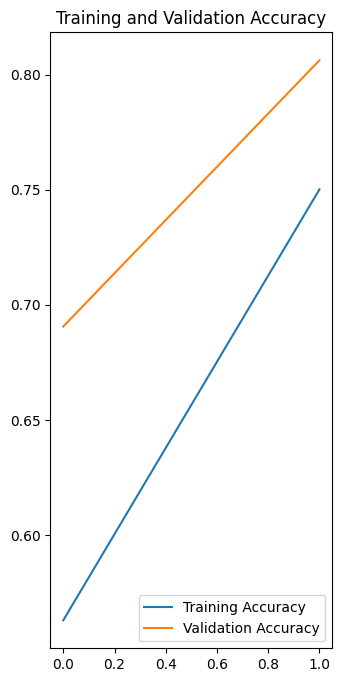

In [30]:

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(epochs)[:2],acc[:2],label='Training Accuracy')
plt.plot(range(epochs)[:2],val_acc[:2],label='Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

Text(0.5, 1.0, 'Training and Validation loss')

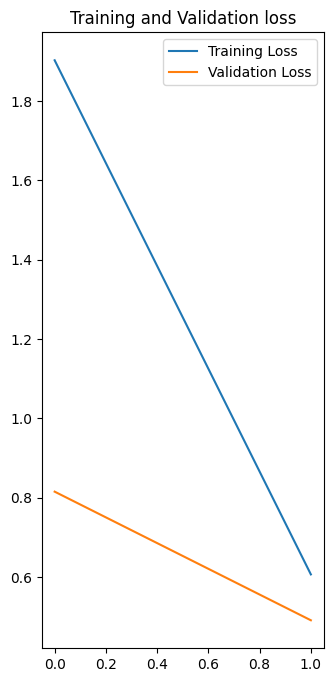

In [31]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(epochs)[:2],loss[:2],label='Training Loss')
plt.plot(range(epochs)[:2],val_loss[:2],label='Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation loss')

First Image to predict
First image's actual label: [Malignant] Pro-B
1/1 [==============================] - 0s 191ms/step
predicted label: [Malignant] Pro-B


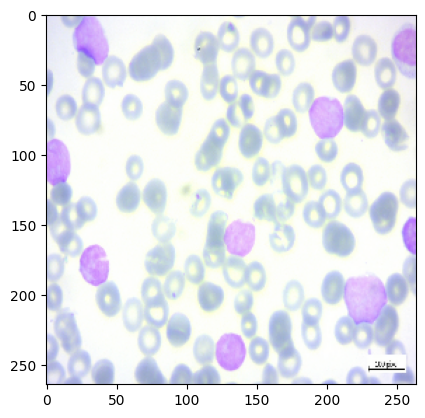

In [32]:
for image_batch,label_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = label_batch[0].numpy()

    print("First Image to predict")
    plt.imshow(first_image)
    print("First image's actual label:",class_names[first_label])

    batch_prediction = model.predict(image_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])]);

In [33]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i])
    img_array = tf.expand_dims(img_array, 0) #create a batch

    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 22ms/step


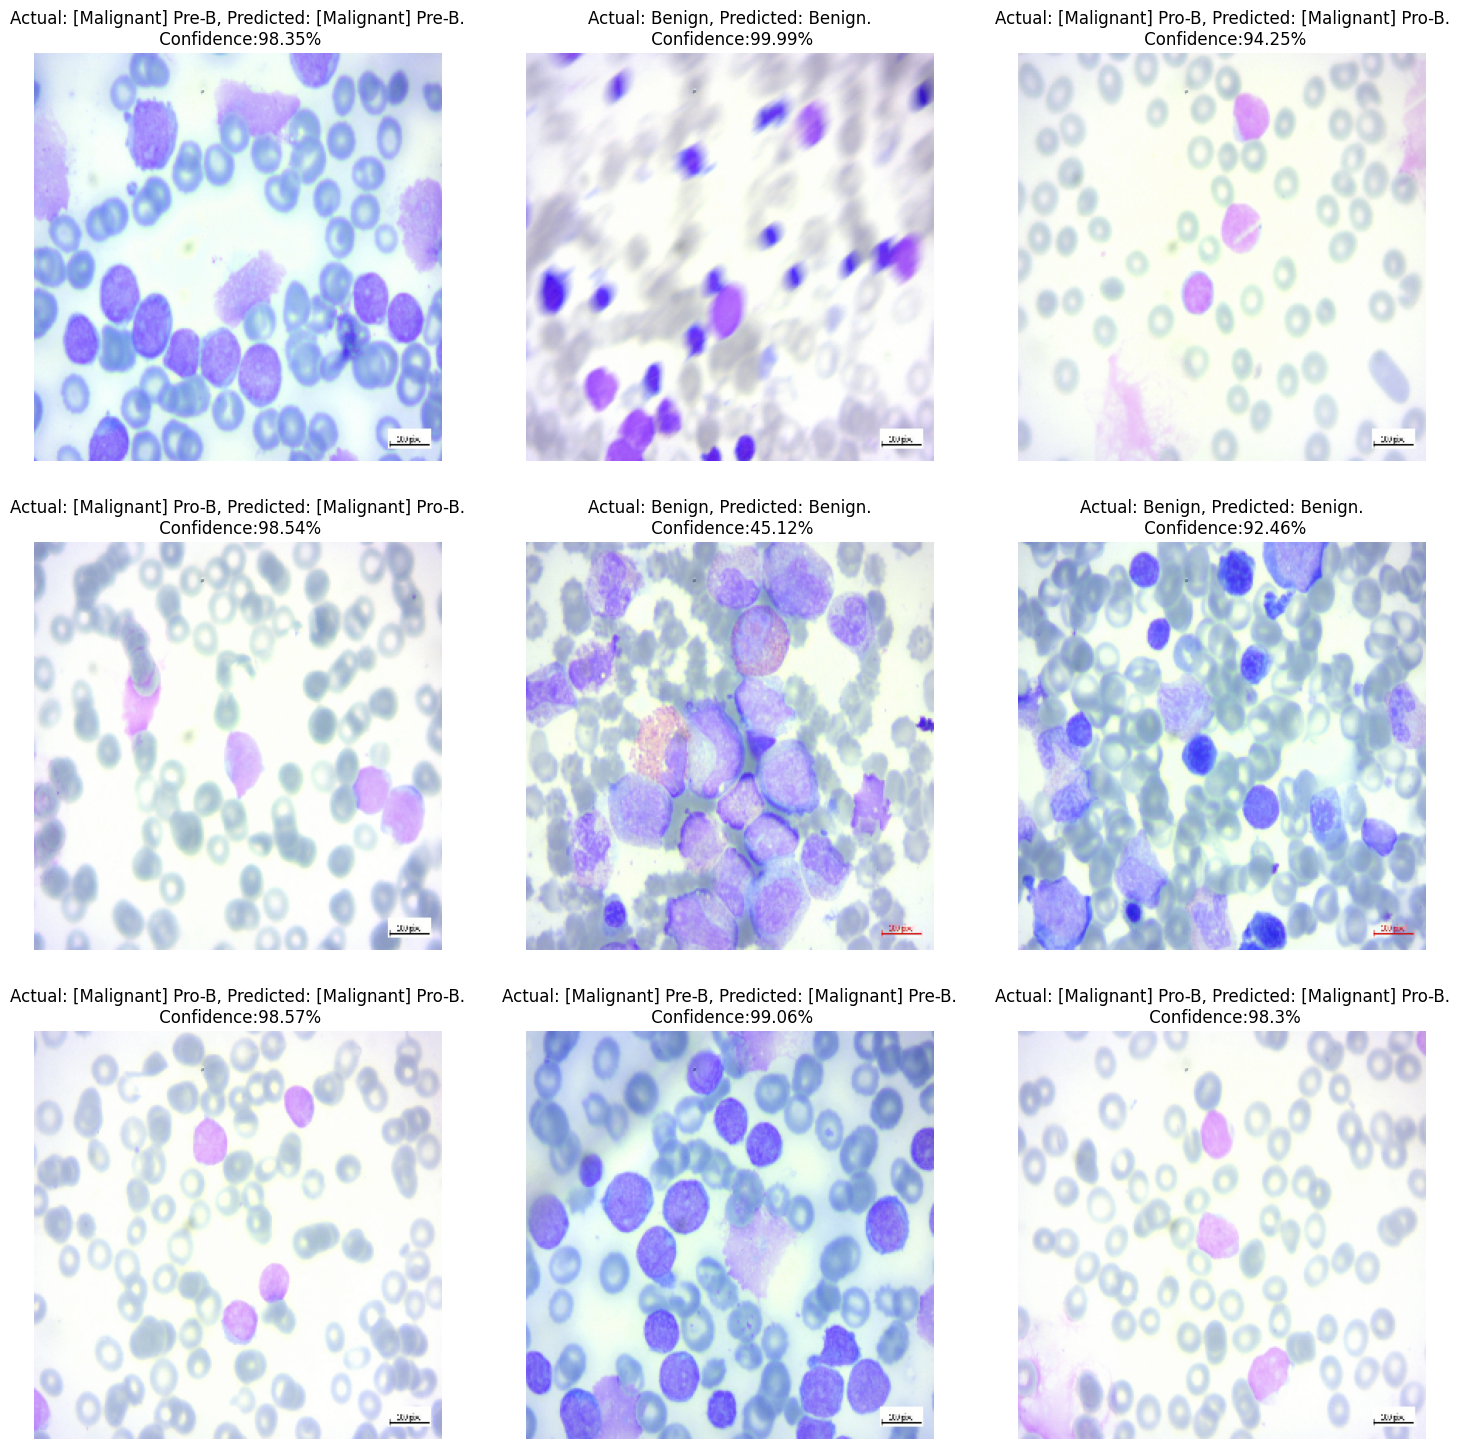

In [34]:
plt.figure(figsize=(18,18))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i])
        actual_class = class_names[labels[i]]
        plt.title(f"Actual: {actual_class}, Predicted: {predicted_class}.\n Confidence:{confidence}%")

        plt.axis("off")

In [51]:
model_version = 1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets


In [52]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def resnet(input_shape, n_classes=4):
  model = Sequential()

  model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
  model.add(MaxPooling2D((2, 2)))

  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(MaxPooling2D((2, 2)))

  model.add(Conv2D(128, (3, 3), activation='relu'))
  model.add(MaxPooling2D((2, 2)))

  model.add(Flatten())

  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.25))

  model.add(Dense(4, activation='softmax'))

  return model

In [53]:
model = resnet((264, 264, 3), 4)

In [54]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 262, 262, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 131, 131, 32)     0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 129, 129, 64)      18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 62, 62, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 31, 31, 128)     

In [55]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [56]:
history = model.fit(
        train_ds, 
        epochs=10, 
        batch_size=BATCH_SIZE,
        validation_data=val_ds, 
        verbose=1)

Epoch 1/10
162/162 [==============================] - 82s 504ms/step - loss: 12.5005 - accuracy: 0.6837 - val_loss: 0.5973 - val_accuracy: 0.8000
Epoch 2/10
162/162 [==============================] - 80s 496ms/step - loss: 0.4724 - accuracy: 0.8183 - val_loss: 0.2469 - val_accuracy: 0.9000
Epoch 3/10
162/162 [==============================] - 80s 496ms/step - loss: 0.3091 - accuracy: 0.8782 - val_loss: 0.1374 - val_accuracy: 0.9469
Epoch 4/10
162/162 [==============================] - 80s 496ms/step - loss: 0.4287 - accuracy: 0.8867 - val_loss: 0.3167 - val_accuracy: 0.8719
Epoch 5/10
162/162 [==============================] - 80s 496ms/step - loss: 0.3258 - accuracy: 0.8797 - val_loss: 0.1561 - val_accuracy: 0.9594
Epoch 6/10
162/162 [==============================] - 81s 499ms/step - loss: 0.2572 - accuracy: 0.9049 - val_loss: 0.1460 - val_accuracy: 0.9500
Epoch 7/10
162/162 [==============================] - 80s 494ms/step - loss: 0.1696 - accuracy: 0.9339 - val_loss: 0.2107 - val_a

In [67]:
scores = model.evaluate(test_ds)

21/21 [==============================] - 2s 98ms/step - loss: 0.1303 - accuracy: 0.9524


In [68]:
scores

[0.13032659888267517, 0.9523809552192688]

In [69]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 162}

In [70]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [71]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss= history.history['loss']
val_loss = history.history['val_loss']


Text(0.5, 1.0, 'Training and Validation Accuracy')

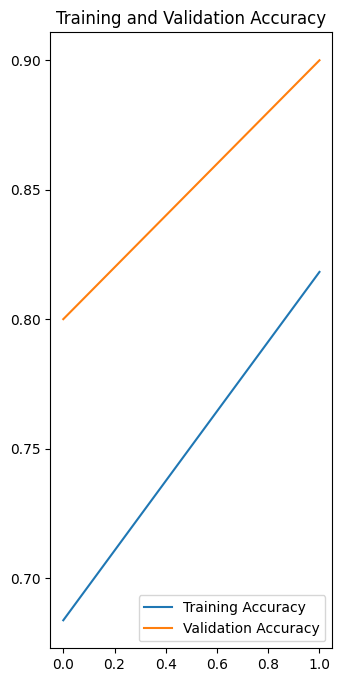

In [72]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(epochs)[:2],acc[:2],label='Training Accuracy')
plt.plot(range(epochs)[:2],val_acc[:2],label='Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

Text(0.5, 1.0, 'Training and Validation loss')

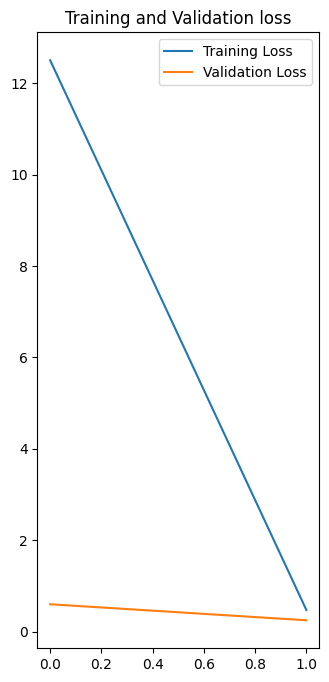

In [73]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(epochs)[:2],loss[:2],label='Training Loss')
plt.plot(range(epochs)[:2],val_loss[:2],label='Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation loss')

First Image to predict
First image's actual label: [Malignant] Pre-B
1/1 [==============================] - 0s 116ms/step
predicted label: [Malignant] Pre-B


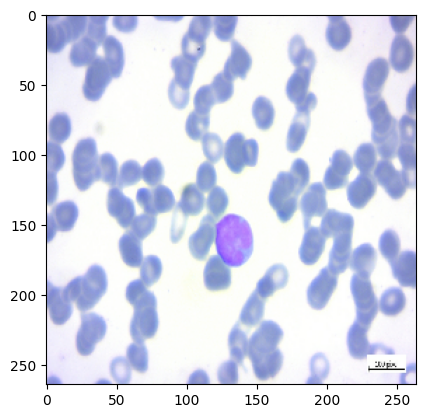

In [74]:
for image_batch,label_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = label_batch[0].numpy()

    print("First Image to predict")
    plt.imshow(first_image)
    print("First image's actual label:",class_names[first_label])

    batch_prediction = model.predict(image_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])]);

In [75]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i])
    img_array = tf.expand_dims(img_array, 0) #create a batch

    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 24ms/step


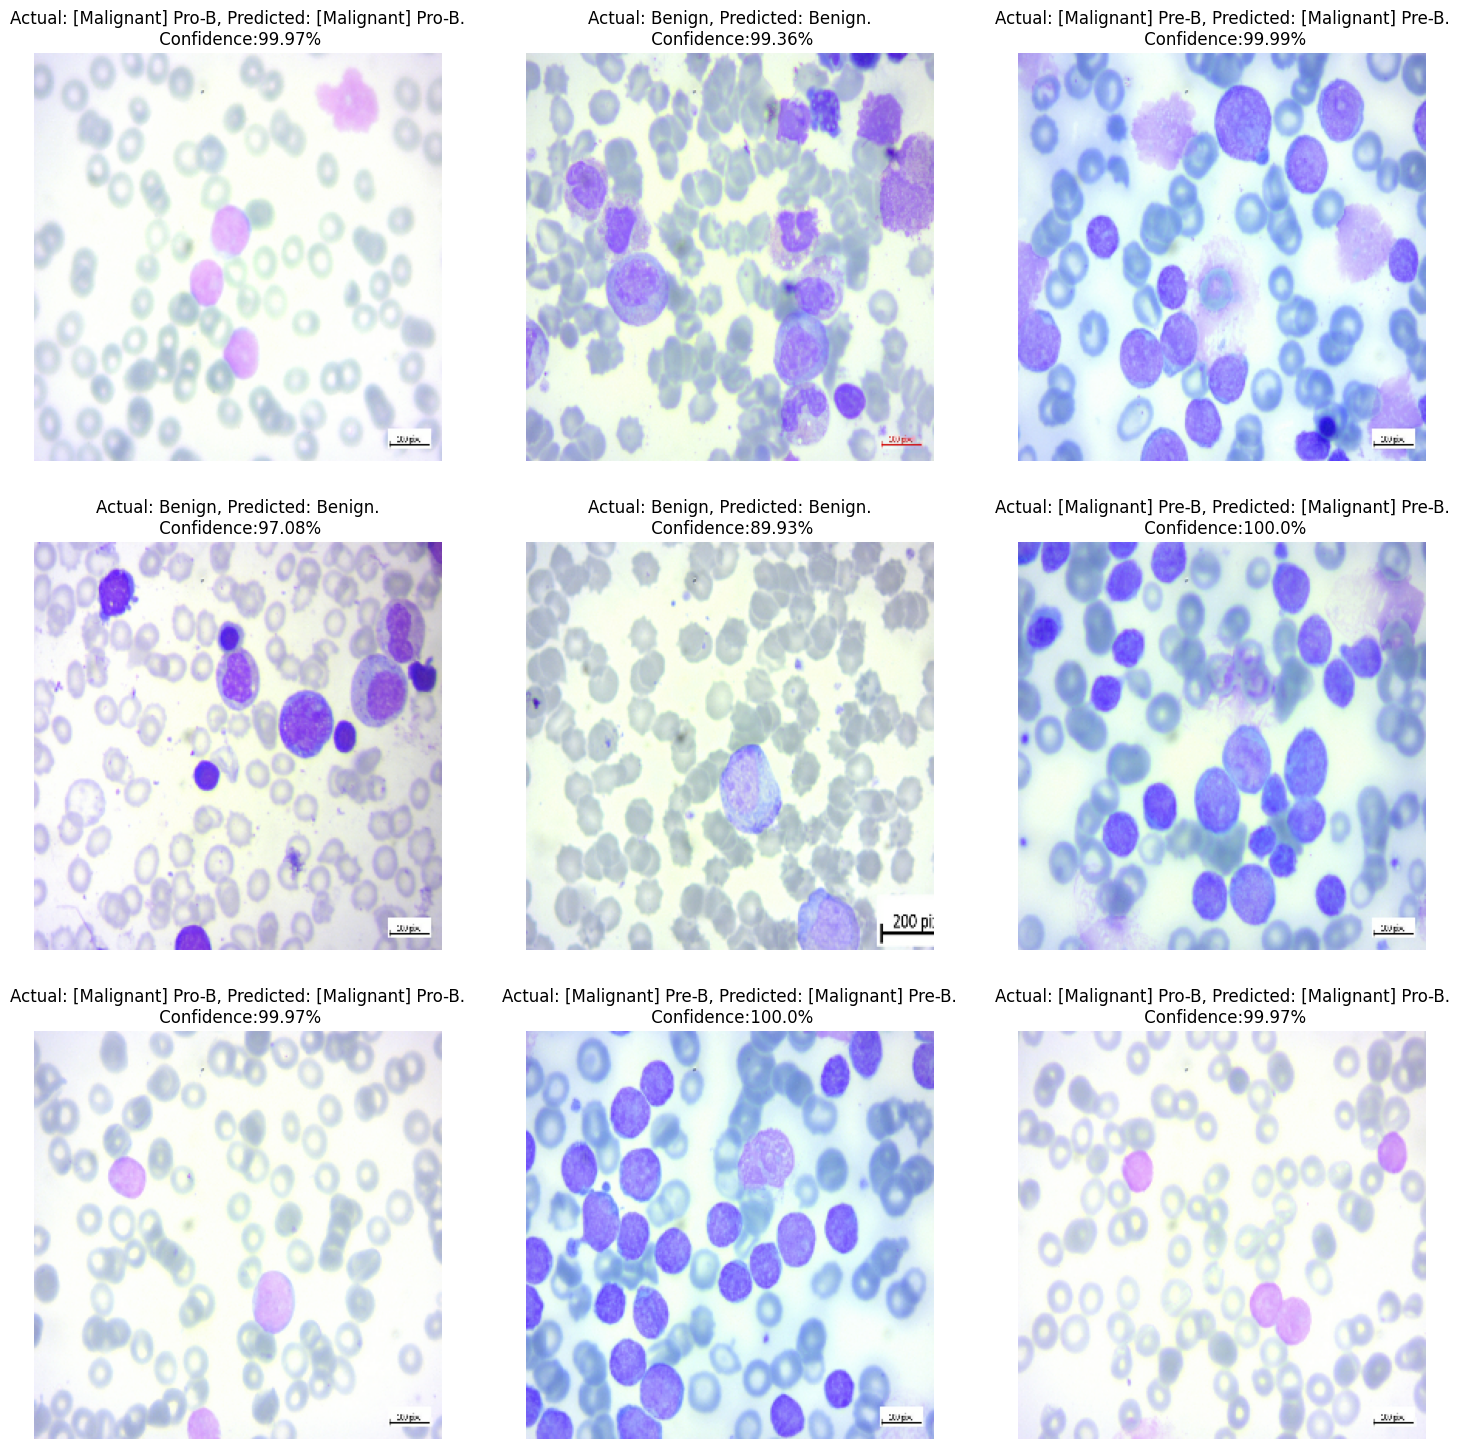

In [76]:
plt.figure(figsize=(18,18))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i])
        actual_class = class_names[labels[i]]
        plt.title(f"Actual: {actual_class}, Predicted: {predicted_class}.\n Confidence:{confidence}%")

        plt.axis("off")

In [77]:
model_version = 2
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/2\assets


INFO:tensorflow:Assets written to: ../models/2\assets
